In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Accuracy: 0.889
Brier Score: 0.0711
Baseline Brier Score (always predict 0.5): 0.2500


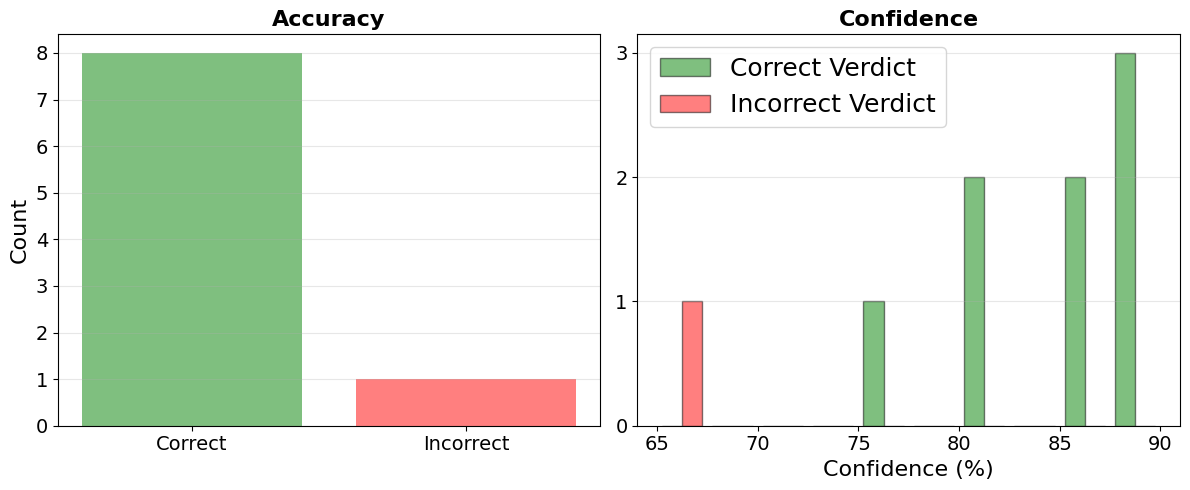


Brier Score: 0.0711
Baseline Brier Score: 0.2500
Improvement: 0.1789


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *

human_verdicts_file = '../results/human/human_verdicts.jsonl'
human_df = pd.read_json(human_verdicts_file, lines=True)

run_id = '0vayjit'
human_df = human_df[human_df['run_id'] == run_id]

debates_df = prepare_df(['debates'])
debates_df = debates_df[debates_df['run_id_debates'] == run_id]

merged = human_df.merge(debates_df[['run_id_debates', 'record_id_debates', 'correct_idx_debates']], 
                        left_on=['run_id', 'record_id'], 
                        right_on=['run_id_debates', 'record_id_debates'])

merged['verdict'] = merged['verdict'].astype(int)
merged['correct_idx_debates'] = merged['correct_idx_debates'].astype(int)
merged['confidence'] = merged['confidence'].astype(float) / 100.0

merged['is_correct'] = merged['verdict'] == merged['correct_idx_debates']

accuracy = merged['is_correct'].mean()
print(f"Accuracy: {accuracy:.3f}")

def compute_brier_score(merged_df):
    brier_scores = []
    for _, row in merged_df.iterrows():
        verdict = row['verdict']
        confidence = row['confidence']
        correct = row['correct_idx_debates']
        
        if verdict == correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(merged)
print(f"Brier Score: {brier_score:.4f}")

baseline_brier = 0.25
print(f"Baseline Brier Score (always predict 0.5): {baseline_brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Correct', 'Incorrect'], [merged['is_correct'].sum(), (~merged['is_correct']).sum()], 
        color=['green', 'red'], alpha=0.5)
ax1.set_ylabel('Count', fontsize=16)
# ax1.set_title(f'Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold')
ax1.set_title(f'Accuracy',  fontsize=16, fontweight='bold')

ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='both', labelsize=14)

correct_conf = merged[merged['is_correct']]['confidence'] * 100
incorrect_conf = merged[~merged['is_correct']]['confidence'] * 100

ax2.hist([correct_conf, incorrect_conf], bins=10, alpha=0.5, 
         label=['Correct Verdict', 'Incorrect Verdict'], color=['green', 'red'], edgecolor='black')
ax2.set_xlabel('Confidence (%)', fontsize=16)
ax2.set_title('Confidence', fontsize=16, fontweight='bold')
ax2.legend(fontsize=18)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\nBrier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")